In [20]:
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
np.random.seed(42)
n = 100
date = pd.date_range(start="2022-01-01", periods=n, freq="D")
usd = np.random.normal(100, 5, size=n)
btc = np.random.normal(30000, 500, size=n)
holiday = (np.arange(n) % 30 == 0).astype(int)

y = (
    0.1 * np.arange(n) 
    + 10 * np.sin(2 * np.pi * np.arange(n) / 7)
    + 0.05 * usd
    - 0.001 * btc
    + 5 * holiday
    + np.random.normal(0, 2, n)
)

df = pd.DataFrame({
    "date": date,
    "y": y,
    "usd": usd,
    "btc": btc,
    "holiday": holiday
})

In [32]:
df

,date,y,usd,btc,holiday
0,2022-01-01,-18.452561,102.483571,29292.314629,1
1,2022-01-02,-15.784360,99.308678,29789.677339,0
2,2022-01-03,-12.551339,103.238443,29828.642742,0
3,2022-01-04,-17.471662,107.615149,29598.861365,0
4,2022-01-05,-31.672072,98.829233,29919.357144,0
...,...,...,...,...,...
95,2022-04-06,-21.783194,92.682425,30192.658690,0
96,2022-04-07,-22.834121,101.480601,29558.071282,0
97,2022-04-08,-22.515315,101.305276,30076.862553,0
98,2022-04-09,-13.602102,100.025567,30029.104359,0


In [23]:
train_size = int(n * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

In [24]:
model = DLT(
    response_col="y",
    date_col="date",
    regressor_col=["usd", "btc", "holiday"],
    seasonality=7,
    estimator="stan-mcmc",
    num_warmup=800,
    num_sample=1200,
    prediction_percentiles=[5,25,50,75,95]
)

In [25]:
model.fit(df=df_train)
pred_df = model.predict(df=df)

2025-09-08 11:29:50 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 200 and samples(per chain): 300.
INFO:orbit:Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 200 and samples(per chain): 300.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

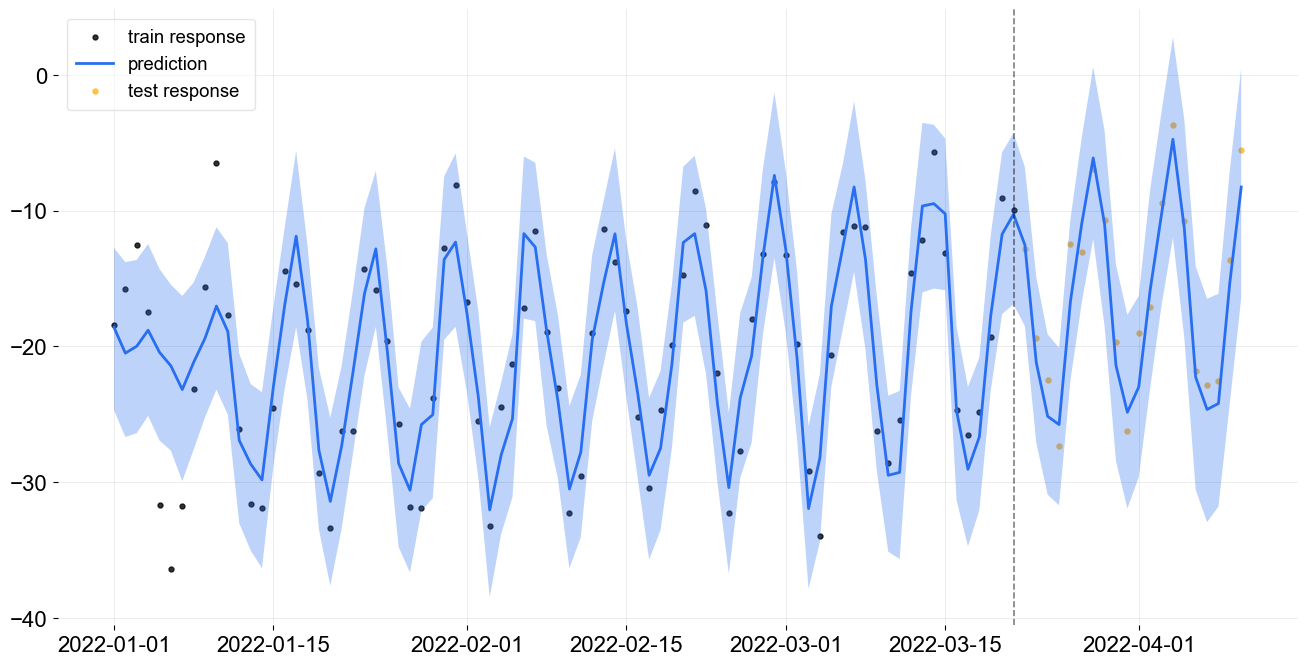

<Axes: >

In [30]:
plot_predicted_data(
    training_actual_df=df_train,
    predicted_df=pred_df,
    test_actual_df=df_test,
    date_col="date",
    actual_col="y"
)

In [27]:
posterior = model.get_regression_coefs()
posterior.head()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,usd,Regular,0.119183,0.012865,0.228429,0.965833,0.034167
1,btc,Regular,-0.001677,-0.002850,-0.000442,0.009167,0.990833
2,holiday,Regular,1.156790,-0.192516,2.471658,0.914167,0.085833


In [31]:
pred_df

,date,prediction_5,prediction_25,prediction,prediction_75,prediction_95
0,2022-01-01,-24.683015,-20.830523,-18.595878,-16.134464,-12.740479
1,2022-01-02,-26.672280,-23.021408,-20.495362,-17.974727,-13.793323
2,2022-01-03,-26.396086,-22.379403,-19.988541,-17.355217,-13.626189
3,2022-01-04,-25.116591,-21.176059,-18.806518,-16.418047,-12.455695
4,2022-01-05,-26.928664,-22.712882,-20.434940,-17.910603,-14.290843
...,...,...,...,...,...,...
95,2022-04-06,-30.556019,-25.434078,-22.271802,-19.084969,-14.091015
96,2022-04-07,-32.947459,-28.030551,-24.648628,-21.679207,-16.491113
97,2022-04-08,-31.805353,-27.343419,-24.207213,-21.055632,-16.127917
98,2022-04-09,-24.174013,-18.344562,-15.289616,-11.990392,-7.011746
